In [40]:
# imports
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# set up environment
dim = 2
grid_size = {'x': 20, 'y': 20}
domain_size = {'x': 20, 'y': 20}

# boundary_condition
# constant boundary condition
bc_left = 0
bc_right = 0
bc_top = 0
bc_bottom = 0

delta_x = domain_size['x'] / grid_size['x']
delta_y = domain_size['y'] / grid_size['y'] 

alpha_x = np.random.random((grid_size['x'],grid_size['y']))
alpha_y = np.ones((grid_size['x'],grid_size['y']))

time_step = 0.1

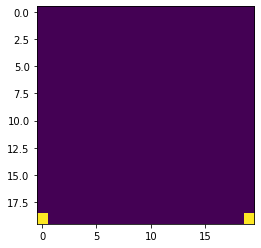

In [3]:
# initialize environment with start values
C_t = np.zeros((grid_size['x'],grid_size['y']))
C_t[19,0] = 2000
C_t[19,19] = 2000


plt.imshow(C_t, vmin=0, vmax=2000)
plt.show()

In [41]:
# calculate mean between two cells
def alpha_interblock(alpha1, alpha2, harmonic=True):
    if not harmonic:
        return 0.5 * (alpha1 + alpha2)
    else:
        return 2 / ((1/alpha1) + (1/alpha2))

In [217]:
def sub(delta_t, delta_x):
    return delta_t / (2 * delta_x**2)

In [260]:
################
### CONSTANT ###
################

# creates the coeffiecient matrix for a given row
def create_coeff_matrix(alpha_x, row_index, s_x):
    # alias
    r = row_index

    # a square matrix of column^2 dimension for the coefficients
    cm = np.zeros((alpha_x.shape[1],alpha_x.shape[1]))

    # top left
    cm[0,0] = 1 + s_x * (alpha_interblock(alpha_x[r,0], alpha_x[r,1]) + 2 * alpha_x[r,0]) # alpha_x[0,0]
    cm[0,1] = -s_x * alpha_interblock(alpha_x[r, 0], alpha_x[r, 1])

    # inner cells
    for i_cm in range(1, cm.shape[0]-1):
        j_alpha = i_cm #- 1 # ???????
        cm[i_cm,i_cm-1] = -s_x * alpha_interblock(alpha_x[r, j_alpha-1], alpha_x[r, j_alpha])
        cm[i_cm,i_cm] = 1 + s_x * (alpha_interblock(alpha_x[r,j_alpha], alpha_x[r, j_alpha+1]) \
                            + alpha_interblock(alpha_x[r, j_alpha], alpha_x[r, j_alpha-1]))
        cm[i_cm,i_cm+1] = -s_x * alpha_interblock(alpha_x[r, j_alpha], alpha_x[r, j_alpha+1])


    # bottom right
    n = cm.shape[0]-1
    cm[n,n-1] = -s_x * alpha_interblock(alpha_x[r, n-1], alpha_x[r, n]) ## changed to - !!!
    cm[n,n] = 1 + s_x * (alpha_interblock(alpha_x[r, n], alpha_x[r, n-1]) + 2 * alpha_x[r,n]) # alpha_x[n,n]? -> changed to [r,n]!!! and changed to +alpha_interblock

    # print(cm)
    return cm

# creates the solution vector for a given row
# s_x, alpha_x, row_index?
def create_solution_vector(concentrations, alpha_x, alpha_y, row_index, s_x, s_y, bc_left, bc_right, bc_top, bc_bottom):

    sv = np.zeros(concentrations.shape[1])
    # print(concentrations.shape[1])
    # print(sv.shape[0])
    # print(row_index)

    # inner rows
    if row_index > 0 and row_index < concentrations.shape[0]-1:
        for i in range(0, sv.shape[0]):
            sv[i] = s_y * alpha_interblock(alpha_y[row_index+1,i],alpha_y[row_index,i]) * concentrations[row_index+1,i] \
                    + (
                        1 - s_y * (
                            alpha_interblock(alpha_y[row_index+1,i], alpha_y[row_index,i]) \
                            + alpha_interblock(alpha_y[row_index,i], alpha_y[row_index-1,i])
                            )
                        ) * concentrations[row_index,i] \
                    + s_y * alpha_interblock(alpha_y[row_index,i], alpha_y[row_index-1,i]) * concentrations[row_index-1,i]

    # first row
    if row_index == 0:
        for i in range(0, sv.shape[0]):
            sv[i] = s_y * alpha_interblock(alpha_y[row_index+1,i],alpha_y[row_index,i]) * concentrations[row_index+1,i] \
                    + (
                        1 - s_y * (
                            alpha_interblock(alpha_y[row_index+1,i], alpha_y[row_index,i]) \
                            + 2 * alpha_y[row_index,i]
                            )
                        ) * concentrations[row_index,i] \
                    + s_y * alpha_y[row_index,i] * bc_top


    # last row
    if row_index == concentrations.shape[0]-1:
        for i in range(0, sv.shape[0]):
            i = i
            sv[i] = s_y * alpha_y[row_index,i]*bc_bottom \
                    + (
                        1 - s_y * (
                            2 * alpha_y[row_index,i] \
                            + alpha_interblock(alpha_y[row_index,i], alpha_y[row_index-1,i])
                            )
                        ) * concentrations[row_index,i] \
                    + s_y * alpha_interblock(alpha_y[row_index,i], alpha_y[row_index-1,i]) * concentrations[row_index-1,i]


    # first column (additional fixed concentration change from perpendicular dimension)
    i = 0
    sv[0] += 2 * s_x * alpha_x[row_index,0] * bc_left # alpha_x[row_index,0]?

    # last column (additional fixed concentration change from perpendicular direction)
    n = sv.shape[0]-1
    sv[n] += 2 * s_x * alpha_x[row_index,n] * bc_right

    # print(sv)
    return sv

def calc_sweep(concentrations, alpha_x, alpha_y, s_x, s_y, bc_left, bc_right, bc_top, bc_bottom):

    concentrations_t1 = np.zeros((concentrations.shape[0], concentrations.shape[1]))

    for i in range(concentrations.shape[0]):
        A = create_coeff_matrix(alpha_x, i, s_x)
        # print(i)
        b = create_solution_vector(concentrations, alpha_x, alpha_y, i, s_x, s_y, bc_left, bc_right, bc_top, bc_bottom)
        concentrations_t1[i,:] = np.linalg.solve(A,b)

    # print(concentrations_t1)
    return concentrations_t1

def calc_iteration(concentrations, alpha_x, alpha_y, s_x, s_y, bc_left, bc_right, bc_top, bc_bottom):
    concentrations = calc_sweep(concentrations, alpha_x, alpha_y, s_x, s_y, bc_left, bc_right, bc_top, bc_bottom)
    # concentrations = calc_sweep(concentrations, alpha_x, alpha_y, s_x, s_y, bc_left, bc_right, bc_top, bc_bottom, True)
    concentrations = calc_sweep(concentrations.transpose(), alpha_y.transpose(), alpha_x.transpose(), s_y, s_x, bc_top, bc_bottom, bc_left, bc_right).transpose()
    
    # print(concentrations)
    return concentrations


def sim_constant(concentrations, alpha_x, alpha_y, iterations, delta_t, delta_x, delta_y, bc_left, bc_right, bc_top, bc_bottom):
    s_x = sub(delta_t, delta_x)
    s_y = sub(delta_t, delta_y)
    for i in range(iterations):
        concentrations = calc_iteration(concentrations, alpha_x, alpha_y, s_x, s_y, bc_left, bc_right, bc_top, bc_bottom)

    return concentrations


In [279]:
##############
### CLOSED ###
##############

# creates the coeffiecient matrix for a given row
def create_coeff_matrix(alpha_x, row_index, s_x):
    # alias
    r = row_index

    # a square matrix of column^2 dimension for the coefficients
    cm = np.zeros((alpha_x.shape[1],alpha_x.shape[1]))

    # top left
    cm[0,0] = 1 + s_x * alpha_interblock(alpha_x[r,0], alpha_x[r,1]) # alpha_x[0,0]
    cm[0,1] = -s_x * alpha_interblock(alpha_x[r, 0], alpha_x[r, 1])

    # inner cells
    for i_cm in range(1, cm.shape[0]-1):
        j_alpha = i_cm #- 1 # ???????
        cm[i_cm,i_cm-1] = -s_x * alpha_interblock(alpha_x[r, j_alpha-1], alpha_x[r, j_alpha])
        cm[i_cm,i_cm] = 1 + s_x * (alpha_interblock(alpha_x[r,j_alpha], alpha_x[r, j_alpha+1]) \
                            + alpha_interblock(alpha_x[r, j_alpha], alpha_x[r, j_alpha-1]))
        cm[i_cm,i_cm+1] = -s_x * alpha_interblock(alpha_x[r, j_alpha], alpha_x[r, j_alpha+1])


    # bottom right
    n = cm.shape[0]-1
    cm[n,n-1] = -s_x * alpha_interblock(alpha_x[r, n-1], alpha_x[r, n])
    cm[n,n] = 1 + s_x * (alpha_interblock(alpha_x[r, n], alpha_x[r, n-1])) # alpha_x[n,n]? 

    # print(cm)
    return cm

# creates the solution vector for a given row
# s_x, alpha_x, row_index?
def create_solution_vector(concentrations, alpha_x, alpha_y, row_index, s_x, s_y, bc_left, bc_right, bc_top, bc_bottom):

    sv = np.zeros(concentrations.shape[1])
    # print(concentrations.shape[1])
    # print(sv.shape[0])
    # print(row_index)

    # inner rows
    if row_index > 0 and row_index < concentrations.shape[0]-1:
        for i in range(0, sv.shape[0]):
            sv[i] = s_y * alpha_interblock(alpha_y[row_index+1,i],alpha_y[row_index,i]) * concentrations[row_index+1,i] \
                    + (
                        1 - s_y * (
                            alpha_interblock(alpha_y[row_index+1,i], alpha_y[row_index,i]) \
                            + alpha_interblock(alpha_y[row_index,i], alpha_y[row_index-1,i])
                            )
                        ) * concentrations[row_index,i] \
                    + s_y * alpha_interblock(alpha_y[row_index,i], alpha_y[row_index-1,i]) * concentrations[row_index-1,i]

    # first row
    if row_index == 0:
        for i in range(0, sv.shape[0]):
            sv[i] = s_y * alpha_interblock(alpha_y[row_index+1,i],alpha_y[row_index,i]) * concentrations[row_index+1,i] \
                    + (
                        1 - s_y * (
                            alpha_interblock(alpha_y[row_index+1,i], alpha_y[row_index,i]) \
                            )
                        ) * concentrations[row_index,i]


    # last row
    if row_index == sv.shape[0]-1:
        for i in range(0, sv.shape[0]):
            i = i
            sv[i] = (
                        1 - s_y * (
                            alpha_interblock(alpha_y[row_index,i], alpha_y[row_index-1,i])
                            )
                        ) * concentrations[row_index,i] \
                    + s_y * alpha_interblock(alpha_y[row_index,i], alpha_y[row_index-1,i]) * concentrations[row_index-1,i]

    # print(sv)
    return sv

def calc_sweep(concentrations, alpha_x, alpha_y, s_x, s_y, bc_left, bc_right, bc_top, bc_bottom):

    concentrations_t1 = np.zeros((concentrations.shape[0], concentrations.shape[1]))

    for i in range(concentrations.shape[0]):
        A = create_coeff_matrix(alpha_x, i, s_x)
        # print(i)
        b = create_solution_vector(concentrations, alpha_x, alpha_y, i, s_x, s_y, bc_left, bc_right, bc_top, bc_bottom)
        concentrations_t1[i,:] = np.linalg.solve(A,b)

    # print(concentrations_t1)
    return concentrations_t1

def calc_iteration(concentrations, alpha_x, alpha_y, s_x, s_y, bc_left, bc_right, bc_top, bc_bottom):
    concentrations = calc_sweep(concentrations, alpha_x, alpha_y, s_x, s_y, bc_left, bc_right, bc_top, bc_bottom)
    # concentrations = calc_sweep(concentrations, alpha_x, alpha_y, s_x, s_y, bc_left, bc_right, bc_top, bc_bottom, True)
    concentrations = calc_sweep(concentrations.transpose(), alpha_y.transpose(), alpha_x.transpose(), s_y, s_x, bc_top, bc_bottom, bc_left, bc_right).transpose()
    
    # print(concentrations)
    return concentrations


def sim_closed(concentrations, alpha_x, alpha_y, iterations, delta_t, delta_x, delta_y, bc_left, bc_right, bc_top, bc_bottom):
    s_x = sub(delta_t, delta_x)
    s_y = sub(delta_t, delta_y)
    for i in range(iterations):
        concentrations = calc_iteration(concentrations, alpha_x, alpha_y, s_x, s_y, bc_left, bc_right, bc_top, bc_bottom)

    return concentrations


In [280]:
row = 20
col = 20
domain_row = row
domain_col = col
iterations = 100
delta_t = 0.1
delta_x = domain_col / col
delta_y = domain_row / row
bc_left = 0
bc_right = 0
bc_top = 0
bc_bottom = 0


testConcentrations = np.zeros((row,col))
testConcentrations[0,0] = 2000
print("Test Concentrations t=0:")
print(testConcentrations)

# seed = np.random.seed(42)
# testAlpha = np.random.random((row,col)) * 10
testAlpha= np.ones((row,col))
print("\nTest Alpha:")
print(testAlpha)

testConcentrations = sim_closed(testConcentrations, testAlpha, testAlpha, iterations, delta_t, delta_x, delta_y, bc_left, bc_right, bc_top, bc_bottom)
print("\nTest Concentrations t=t+" + str(iterations) + ":")
print(testConcentrations)

Test Concentrations t=0:
[[2000.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0. 

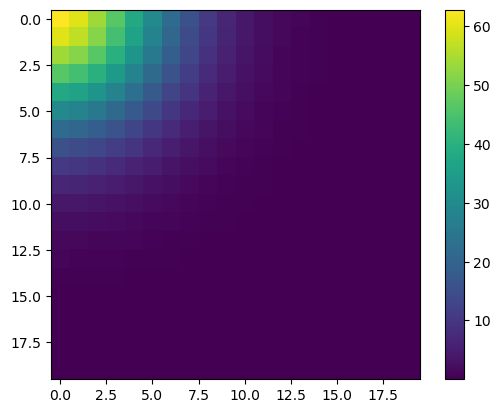

In [281]:
plt.imshow(testConcentrations)
plt.colorbar()
plt.show()